In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from datasets import load_dataset

from matplotlib import rcParams

# rcParams['pdf.fonttype'] = 42
# rcParams['ps.fonttype'] = 42
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
# rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

data = load_dataset("INSAIT-Institute/OPC")

splits = [
    data["best_of_n"].to_pandas(),
    data["pass_at_n"].to_pandas(),
    data["generic"].to_pandas(),
    data["test"].to_pandas(),
    data["matharena"].to_pandas(),
    data["putnambench"].to_pandas()
]

data = pd.concat(splits, ignore_index=True)

/home/jasper/miniconda3/envs/grading/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 320/320 [00:00<00:00, 8908.89 examples/s]


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4934 entries, 0 to 4933
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   problem_id             4934 non-null   object 
 1   problem                4934 non-null   object 
 2   solution               4934 non-null   object 
 3   score                  4934 non-null   object 
 4   feedback               4934 non-null   object 
 5   model_id               4934 non-null   object 
 6   uncertain              4934 non-null   object 
 7   annotations            4934 non-null   object 
 8   judge_id               4934 non-null   object 
 9   competition            4934 non-null   object 
 10  category               4722 non-null   object 
 11  level                  4934 non-null   object 
 12  source                 4934 non-null   object 
 13  url                    4934 non-null   object 
 14  year                   4060 non-null   float64
 15  spli

In [3]:
np.mean(data["uncertain"].apply(np.mean))

np.float64(0.028239427104445342)

In [4]:
np.sum(data["cost"])

np.float64(1370.0682893499998)

In [5]:
len(np.unique(data["problem_id"])), len(data)

(976, 4934)

In [6]:
np.mean(data["score"].apply(np.mean))

np.float64(0.4227469260910688)

In [7]:
np.mean(data["score"].apply(lambda x : len(x) > 1))

np.float64(0.10762059181191731)

In [8]:
data_double = data[np.logical_and(data["score"].apply(lambda x : len(x) > 1), np.logical_not(data["uncertain"].apply(any)))]
overlap = np.mean(data_double["score"].apply(lambda x : len(set(x)) == 1))
overlap

# solve overlap = x ** 2 + (1 - x) ** 2
D = 4 - 4 * 2 * (1 - overlap)
x = (2 + np.sqrt(D)) / 4
print(f"Overlap: {overlap:.3f}, x: {x:.3f}")

Overlap: 0.903, x: 0.949


In [9]:
for split in np.unique(data["split"]):
    print(f"Split: {split}")
    print(f"Number of problems: {len(np.unique(data[data['split'] == split]['problem_id']))}")
    print(f"Number of judgments: {len(data[data['split'] == split])}")

Split: best_of_n
Number of problems: 92
Number of judgments: 252
Split: generic
Number of problems: 611
Number of judgments: 3011
Split: matharena
Number of problems: 78
Number of judgments: 310
Split: pass_at_n
Number of problems: 60
Number of judgments: 477
Split: putnambench
Number of problems: 114
Number of judgments: 564
Split: test
Number of problems: 65
Number of judgments: 320


In [10]:
from collections import Counter

Counter(data["model_id"].apply(lambda x: x.split(" ")[0]))

Counter({'openai/o4-mini--high': 1586,
         'openai/o3': 861,
         'qwen/qwen3_235b_a22b': 860,
         'gemini/gemini-pro-2.5': 846,
         'xai/grok-3-mini-high': 455,
         'deepseek/r1_0528': 326})

In [11]:
data[np.logical_and(data["model_id"] == "openai/o4-mini--high", data["competition"] == "IMOSL")]["score"].apply(np.mean).mean()

np.float64(0.18211920529801323)

In [12]:
from collections import Counter
comps = data["problem_id"].apply(lambda x: x.split("_")[0])
comps_unique = [x.split("_")[0] for x in np.unique(data["problem_id"])]

comp_counts = Counter(comps_unique)

In [13]:
comp_counts

Counter({'IMOSL': 178,
         'putnam': 122,
         'BMOSL': 106,
         'BalticWay': 80,
         'matharena': 78,
         'USAMO': 64,
         'irish': 51,
         'EGMO': 47,
         'IMC': 43,
         'izho': 41,
         'RMM': 33,
         'bmo1': 28,
         'JMO': 25,
         'bmo2': 23,
         'bulgarian-ZMS': 23,
         'bulgarian-PMS': 16,
         'bulgarian-EMT': 10,
         'swiss': 8})

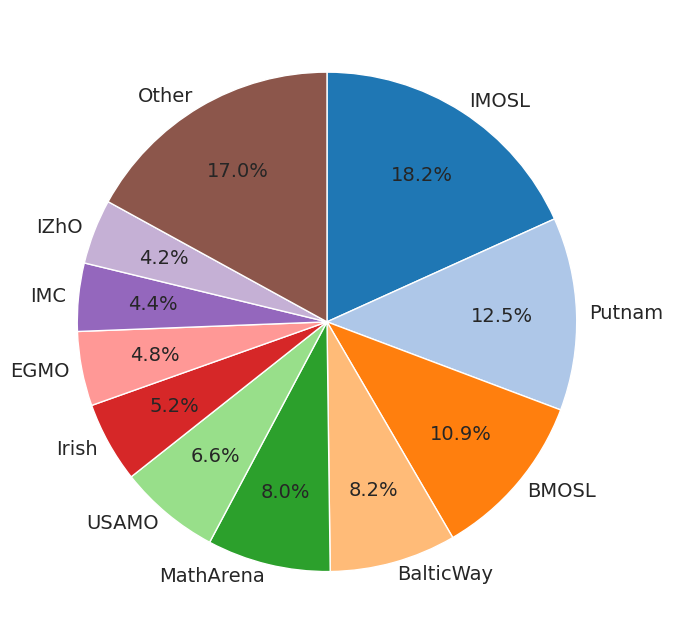

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# Raw data (label, count) tuples
# -------------------------------
data_pie = comp_counts.most_common(50)  # get the top 20 competitions
# convert to dict
mapper = {
    "izho": "IZhO",
    "bmo1": "BMO Prelim.",
    "bmo2": "BMO Final.",
    "irish": "Irish",
    "bulgarian-zms": "Bulgarian-ZMS",
    "bulgarian-pms": "Bulgarian-PMS",
    "bulgarian-emt": "Bulgarian-EMT",
    "matharena": "MathArena",
    "swiss": "Swiss",
    "putnam": "Putnam",

}

data_pie = [(mapper.get(label, label), count) for label, count in data_pie]

# ----------------------------------
# Aggregate any slice under 3 percent
# ----------------------------------
threshold = 0.034                 # 3 %
total = sum(cnt for _, cnt in data_pie)

main_labels = []
main_sizes  = []
other_total = 0

for label, count in data_pie:
    if count / total >= threshold:
        main_labels.append(label)
        main_sizes.append(count)
    else:
        other_total += count

if other_total:                      # add an “Other” slice if needed
    main_labels.append("Other")
    main_sizes.append(other_total)

# -------------------------------
# Plot with Seaborn + Matplotlib
# -------------------------------
sns.set_theme(style="white")
colors = sns.color_palette("tab20", len(main_labels) + 1)

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(
    main_sizes,
    labels=main_labels,
    autopct='%1.1f%%',
    labeldistance=1.05,
    pctdistance=0.7,
    startangle=90,
    counterclock=False,
    colors=colors,
    textprops={'fontsize': 14}
)
# ax.axis('equal')                      # draw a perfect circle
fig.tight_layout()
plt.show()
fig.savefig("comp_pie_chart.pdf")

In [15]:
minimal_model_ids = [
    "openai/o3", "openai/o4-mini--high", "gemini/gemini-pro-2.5", "qwen/qwen3_235b_a22b"
]

data["mean_score"] = data["score"].apply(lambda x: np.mean(x))

def get_data_performance(minimal_model_ids, comps=None, split=None):

    if comps is None:
        data_filtered = data
    else:
        data_filtered = data[data["competition"].apply(lambda x: x in comps)]
    
    if split is not None:
        data_filtered = data_filtered[data_filtered["split"] == split]
    problem_partitions = dict()

    for problem_id in np.unique(data_filtered["problem_id"]):

        df_problem_id = data_filtered[np.logical_and(data_filtered["problem_id"] == problem_id, 
                                            data_filtered["model_id"].apply(lambda x: "(" not in x))]
        if all([model_id in df_problem_id["model_id"].values for model_id in minimal_model_ids]):
            models_appended = ",".join(df_problem_id["model_id"].sort_values().unique())

            if models_appended not in problem_partitions:
                problem_partitions[models_appended] = {
                    model_id: [] for model_id in df_problem_id["model_id"].unique()
                }
            for i, row in df_problem_id.iterrows():
                problem_partitions[models_appended][row["model_id"]].append(row["mean_score"])

    n_problems_per_partition = {k: len(v[list(v.keys())[0]]) for k, v in problem_partitions.items()}
    problem_partitions = {
        partition: {
            model_id: np.mean(scores) for model_id, scores in models.items()
        } for partition, models in problem_partitions.items()
    }
    
    return problem_partitions, n_problems_per_partition

problem_partitions, n_problems_per_partition = get_data_performance(minimal_model_ids)

model_mapper = {
    "gemini/gemini-pro-2.5": r"Gemini-Pro",
    "openai/o3": r"o3",
    "openai/o4-mini--high": r"o4-mini",
    "qwen/qwen3_235b_a22b": r"Qwen3-235B",
    "xai/grok-3-mini-high": r"Grok-Mini",
    "deepseek/r1_0528": r"R1",
}

<>:126: SyntaxWarning: invalid escape sequence '\%'
<>:126: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_191429/1930485747.py:126: SyntaxWarning: invalid escape sequence '\%'
  ax.set_yticklabels([f'${i * 20}\%$' for i in range(n + 1)])
/tmp/ipykernel_191429/1930485747.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] * len(ax.get_xticks()))


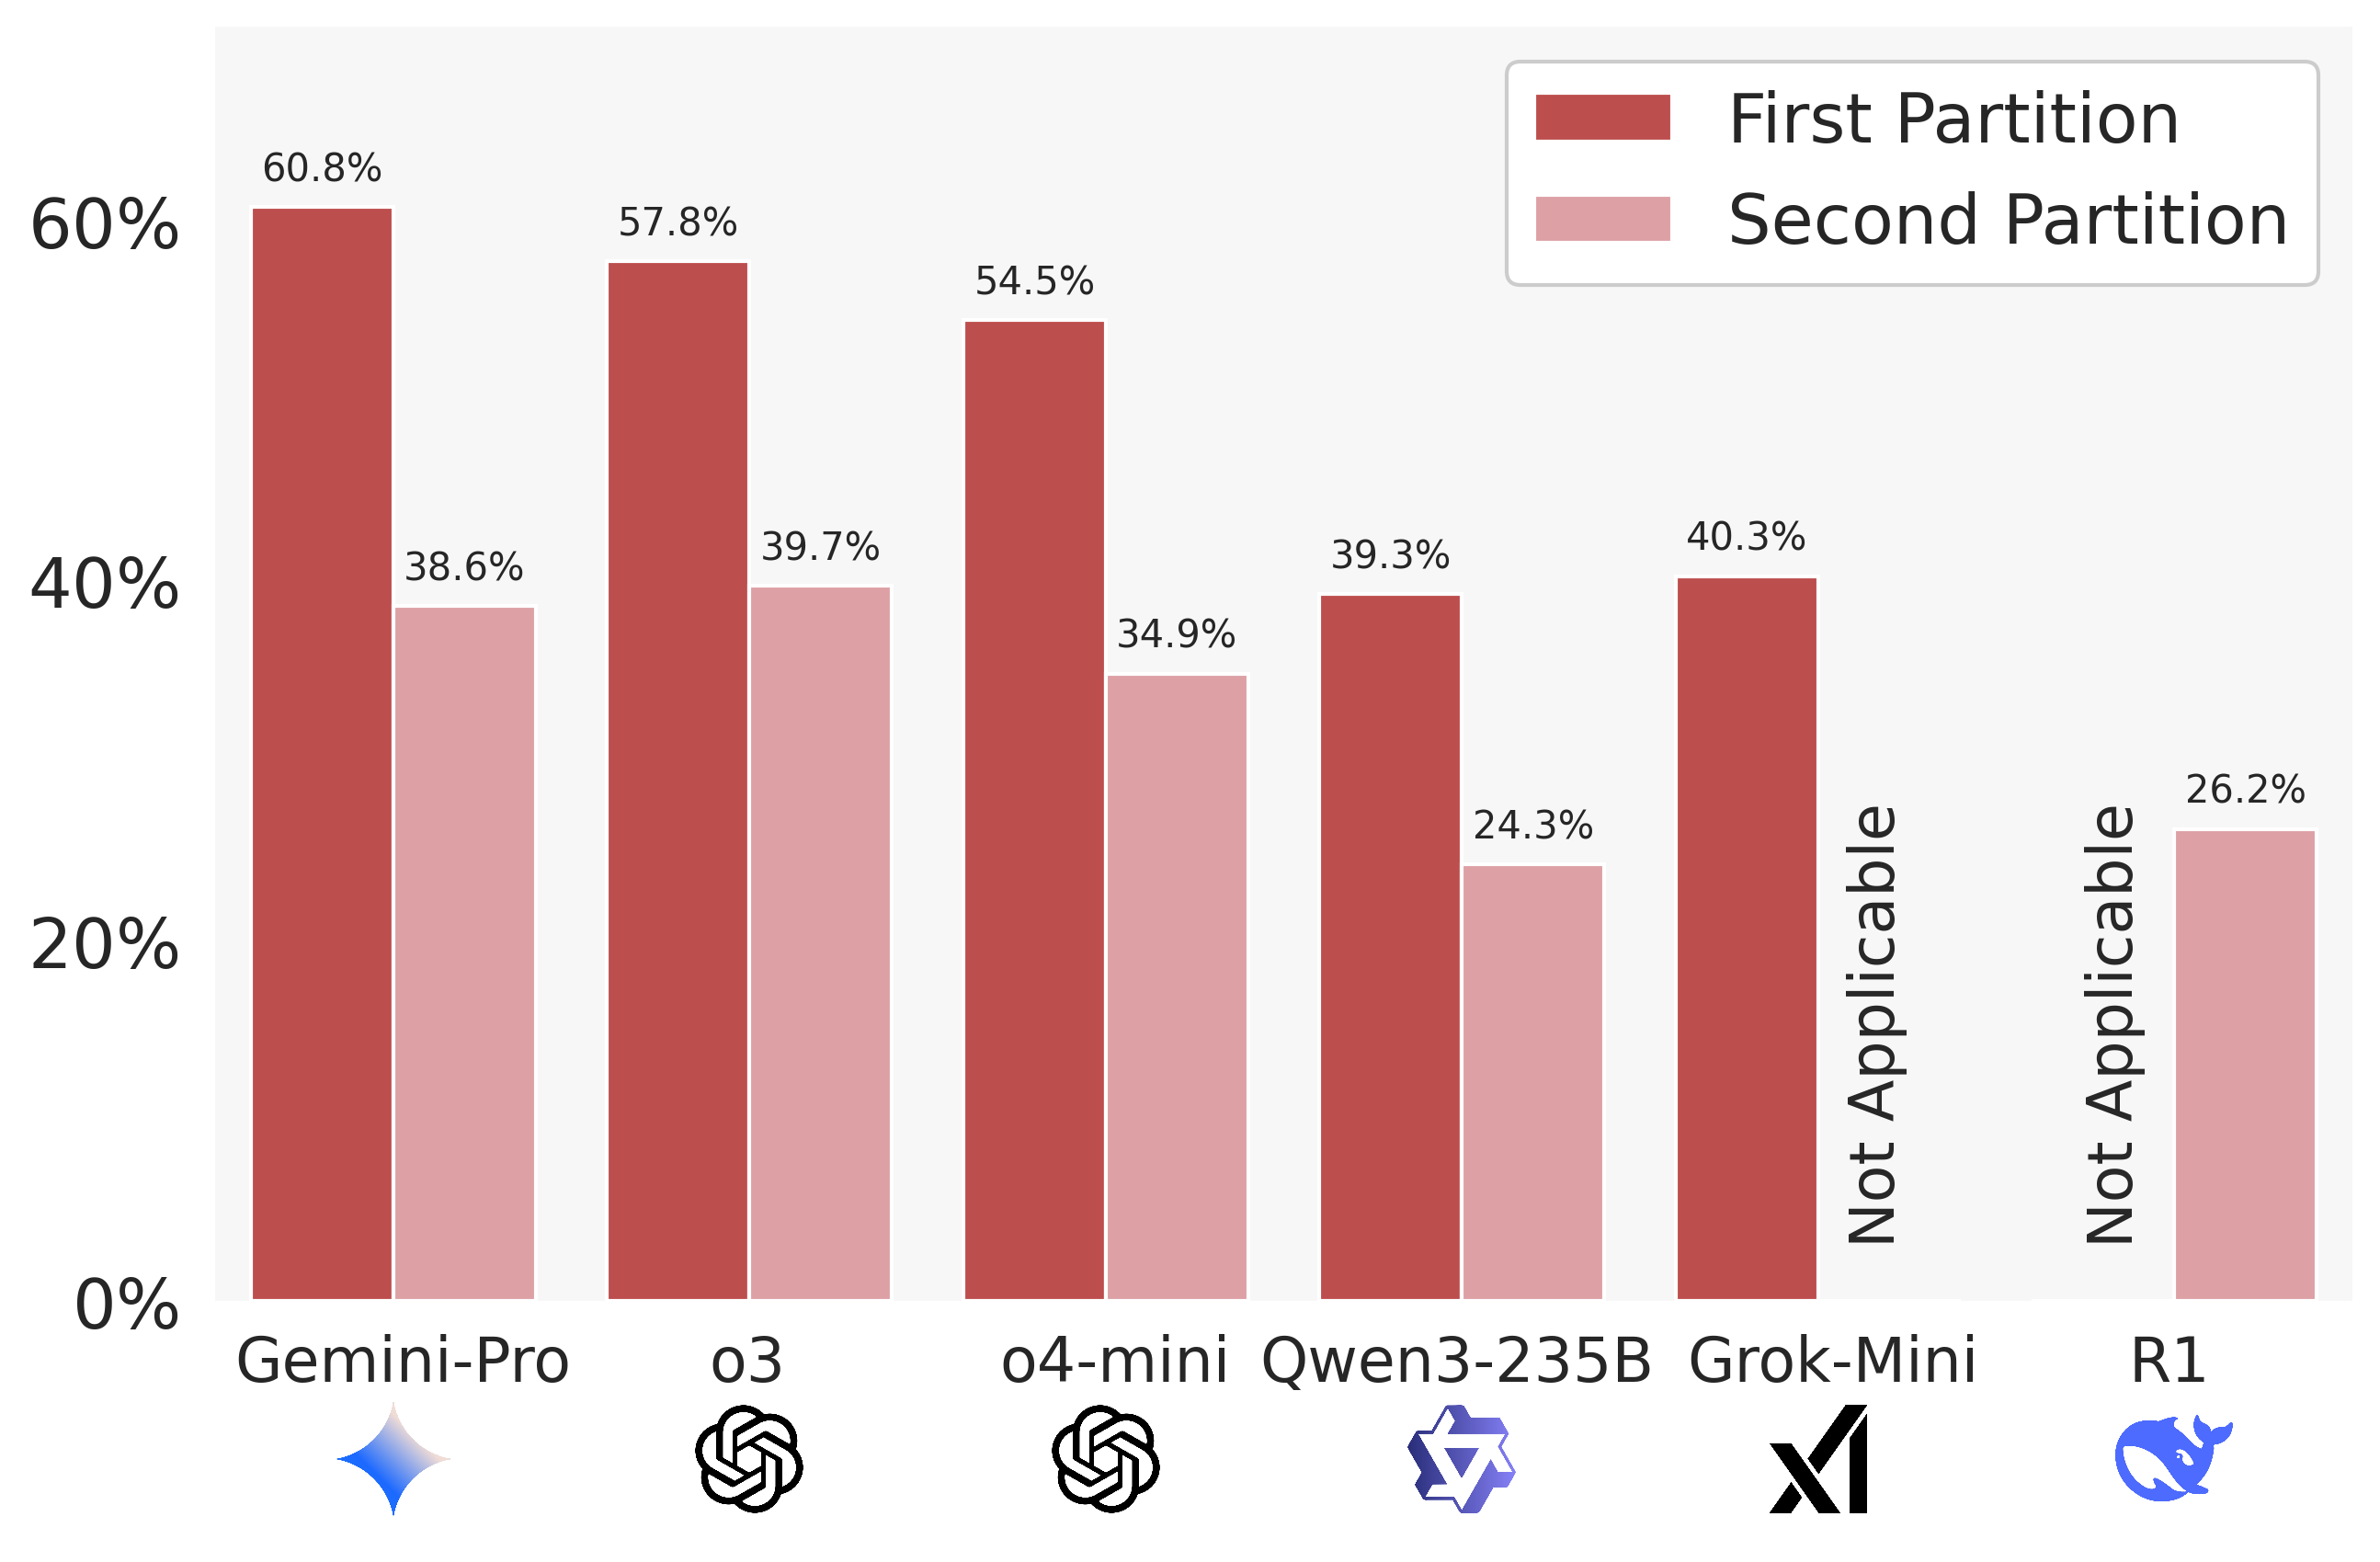

In [16]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot(model_scores, column_mapper, save_file=None, label_size=18, shift_factor=0.05,
         colors=("#cf3b3b", "#e7969c", "#f2b2b2"), legend=True, logos=True,
         add_values=False, values_label_size=18):      # ← NEW PARAMETER
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    # ─────────────────────────────────────────────────────────
    # prepare data & plot
    # ─────────────────────────────────────────────────────────
    df = pd.DataFrame.from_dict(model_scores, orient='index', columns=column_mapper)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Model'}, inplace=True)
    df_melted = df.melt(id_vars='Model', var_name='Accuracy Type', value_name='Accuracy Value')

    sns.barplot(
        data=df_melted, x='Model', y='Accuracy Value', hue='Accuracy Type',
        palette=colors[:len(column_mapper)]
    )

    # ─────────────────────────────────────────────────────────
    # 1. Write “Not applicable” on true-zero bars   (unchanged)
    # ─────────────────────────────────────────────────────────
    for patch in ax.patches:
        if patch.get_height() == 0 and patch.get_width() > 0:
            x = patch.get_x() + patch.get_width() / 2
            x /= len(model_mapper) - 0.6
            ax.text(
                x, 0.03, "Not Applicable",
                ha="center", va="bottom", fontsize=16, rotation=90,
                transform=ax.get_yaxis_transform()
            )

    # ─────────────────────────────────────────────────────────
    # 2. **NEW** – percentages above each bar
    # ─────────────────────────────────────────────────────────
    if add_values:
        text_offset = 0.01        # gap above the bar (in *data* units)
        for patch in ax.patches:
            height = patch.get_height()
            if height > 0:        # skip the “N/A” zeros
                ax.text(
                    patch.get_x() + patch.get_width() / 2,   # bar centre
                    height + text_offset,                    # just above the bar
                    f'{height*100:.1f}%',                    # convert to %
                    ha='center', va='bottom',
                    fontsize=values_label_size
                )

    # rotate x labels
    # plt.xticks(rotation=35, ha="right")
    if logos:
        ax.set_xticklabels([''] * len(ax.get_xticks()))
    x_positions = ax.get_xticks()  # The x locations of each bar group
    models = df['Model'].unique()
    models = [model_mapper.get(model, model) for model in models]

    get_png = {
        "gemini/gemini-pro-2.5": ("gemini.png", 0.0, 0.04),
        "openai/o3": ("openai.png", 0.0, 0.04),
        "openai/o4-mini--high": ("openai.png", -0, 0),
        "deepseek/r1_0528": ("deepseek.png", 0.0, 0.00),
        "qwen/qwen3_235b_a22b": ("qwen.png", 0.04, 0),
        "xai/grok-3-mini-high": ("xai.png", 0.0, 0.04),
    }
    get_png = {
        model_mapper[k]: v for k, v in get_png.items()
    }

    if logos:
        for x, model_name in zip(x_positions, models):
            if model_name in get_png:
                # Read the PNG file
                arr_img = mpimg.imread(get_png[model_name][0])
                # Scale down the image for a better fit
                imagebox = OffsetImage(arr_img, zoom=0.03)
                ab = AnnotationBbox(
                    imagebox, 
                    (x, -0.17),           # place at x, near 0 (the bottom)
                    frameon=False, 
                    xycoords=('data', 'axes fraction'),  # x in data coords, y in fraction of y-axis
                    box_alignment=(0.5, 0)               # anchor the image center at the bottom center
                )
                
                # Add it to the axes
                ax.add_artist(ab)
            
            # Optionally, add text below or next to the image
            # For example, rotate the text and place it slightly below the x-axis
            ax.text(
                x + shift_factor * len(model_name) + get_png[model_name][1],  # shift right from x to avoid overlapping with bar
                -0.025,  # shift downward from 0 (in axes fraction) to avoid overlapping with bar
                model_name, 
                ha='right', 
                va='top', 
                fontsize=16,
                transform=ax.get_xaxis_transform()  # so it stays under the tick, not in data coords
            )



    # set font size of labels, ticks, and legend
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis='both', which='major', labelsize=label_size)
    if legend:
        leg = plt.legend(loc='upper right', fontsize=label_size)
        leg.get_frame().set_alpha(1)
    else:
        leg = plt.legend([], [], loc='upper right', fontsize=label_size)
        leg.set_visible(False)

    plt.tick_params(axis='y', which='both', left=False, right=False)
    sns.despine(left=True, bottom=True)
    # set background color to grey
    ax.set_facecolor((0.97,0.97,0.97))

    
    # ax.grid(axis='y', linestyle='--', alpha=1)  # Light dashed horizontal lines
    # ax.set_axisbelow(True)  # Ensure gridlines are drawn below all other plot elements
    max_value = df_melted['Accuracy Value'].max()
    ax.set_ylim(0, max_value + 0.1)
    n = int((max_value + 0.1) * 5)  # Scale to 5% increments
    ax.set_yticks([i / 5 for i in range(n + 1)])
    ax.set_yticklabels([f'${i * 20}\%$' for i in range(n + 1)])

    if save_file:
        fig.savefig(save_file, bbox_inches='tight')

problem_partitions = {
    partition: value for partition, value in problem_partitions.items() if partition.count(",") > 3
}
model_scores = {
    model_id: [partition.get(model_id, 0) for partition in problem_partitions.values()] for model_id in model_mapper.keys()
}

plot(model_scores, ["First Partition", "Second Partition"], save_file="main.pdf", add_values=True, values_label_size=10,)

/tmp/ipykernel_191429/1930485747.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] * len(ax.get_xticks()))


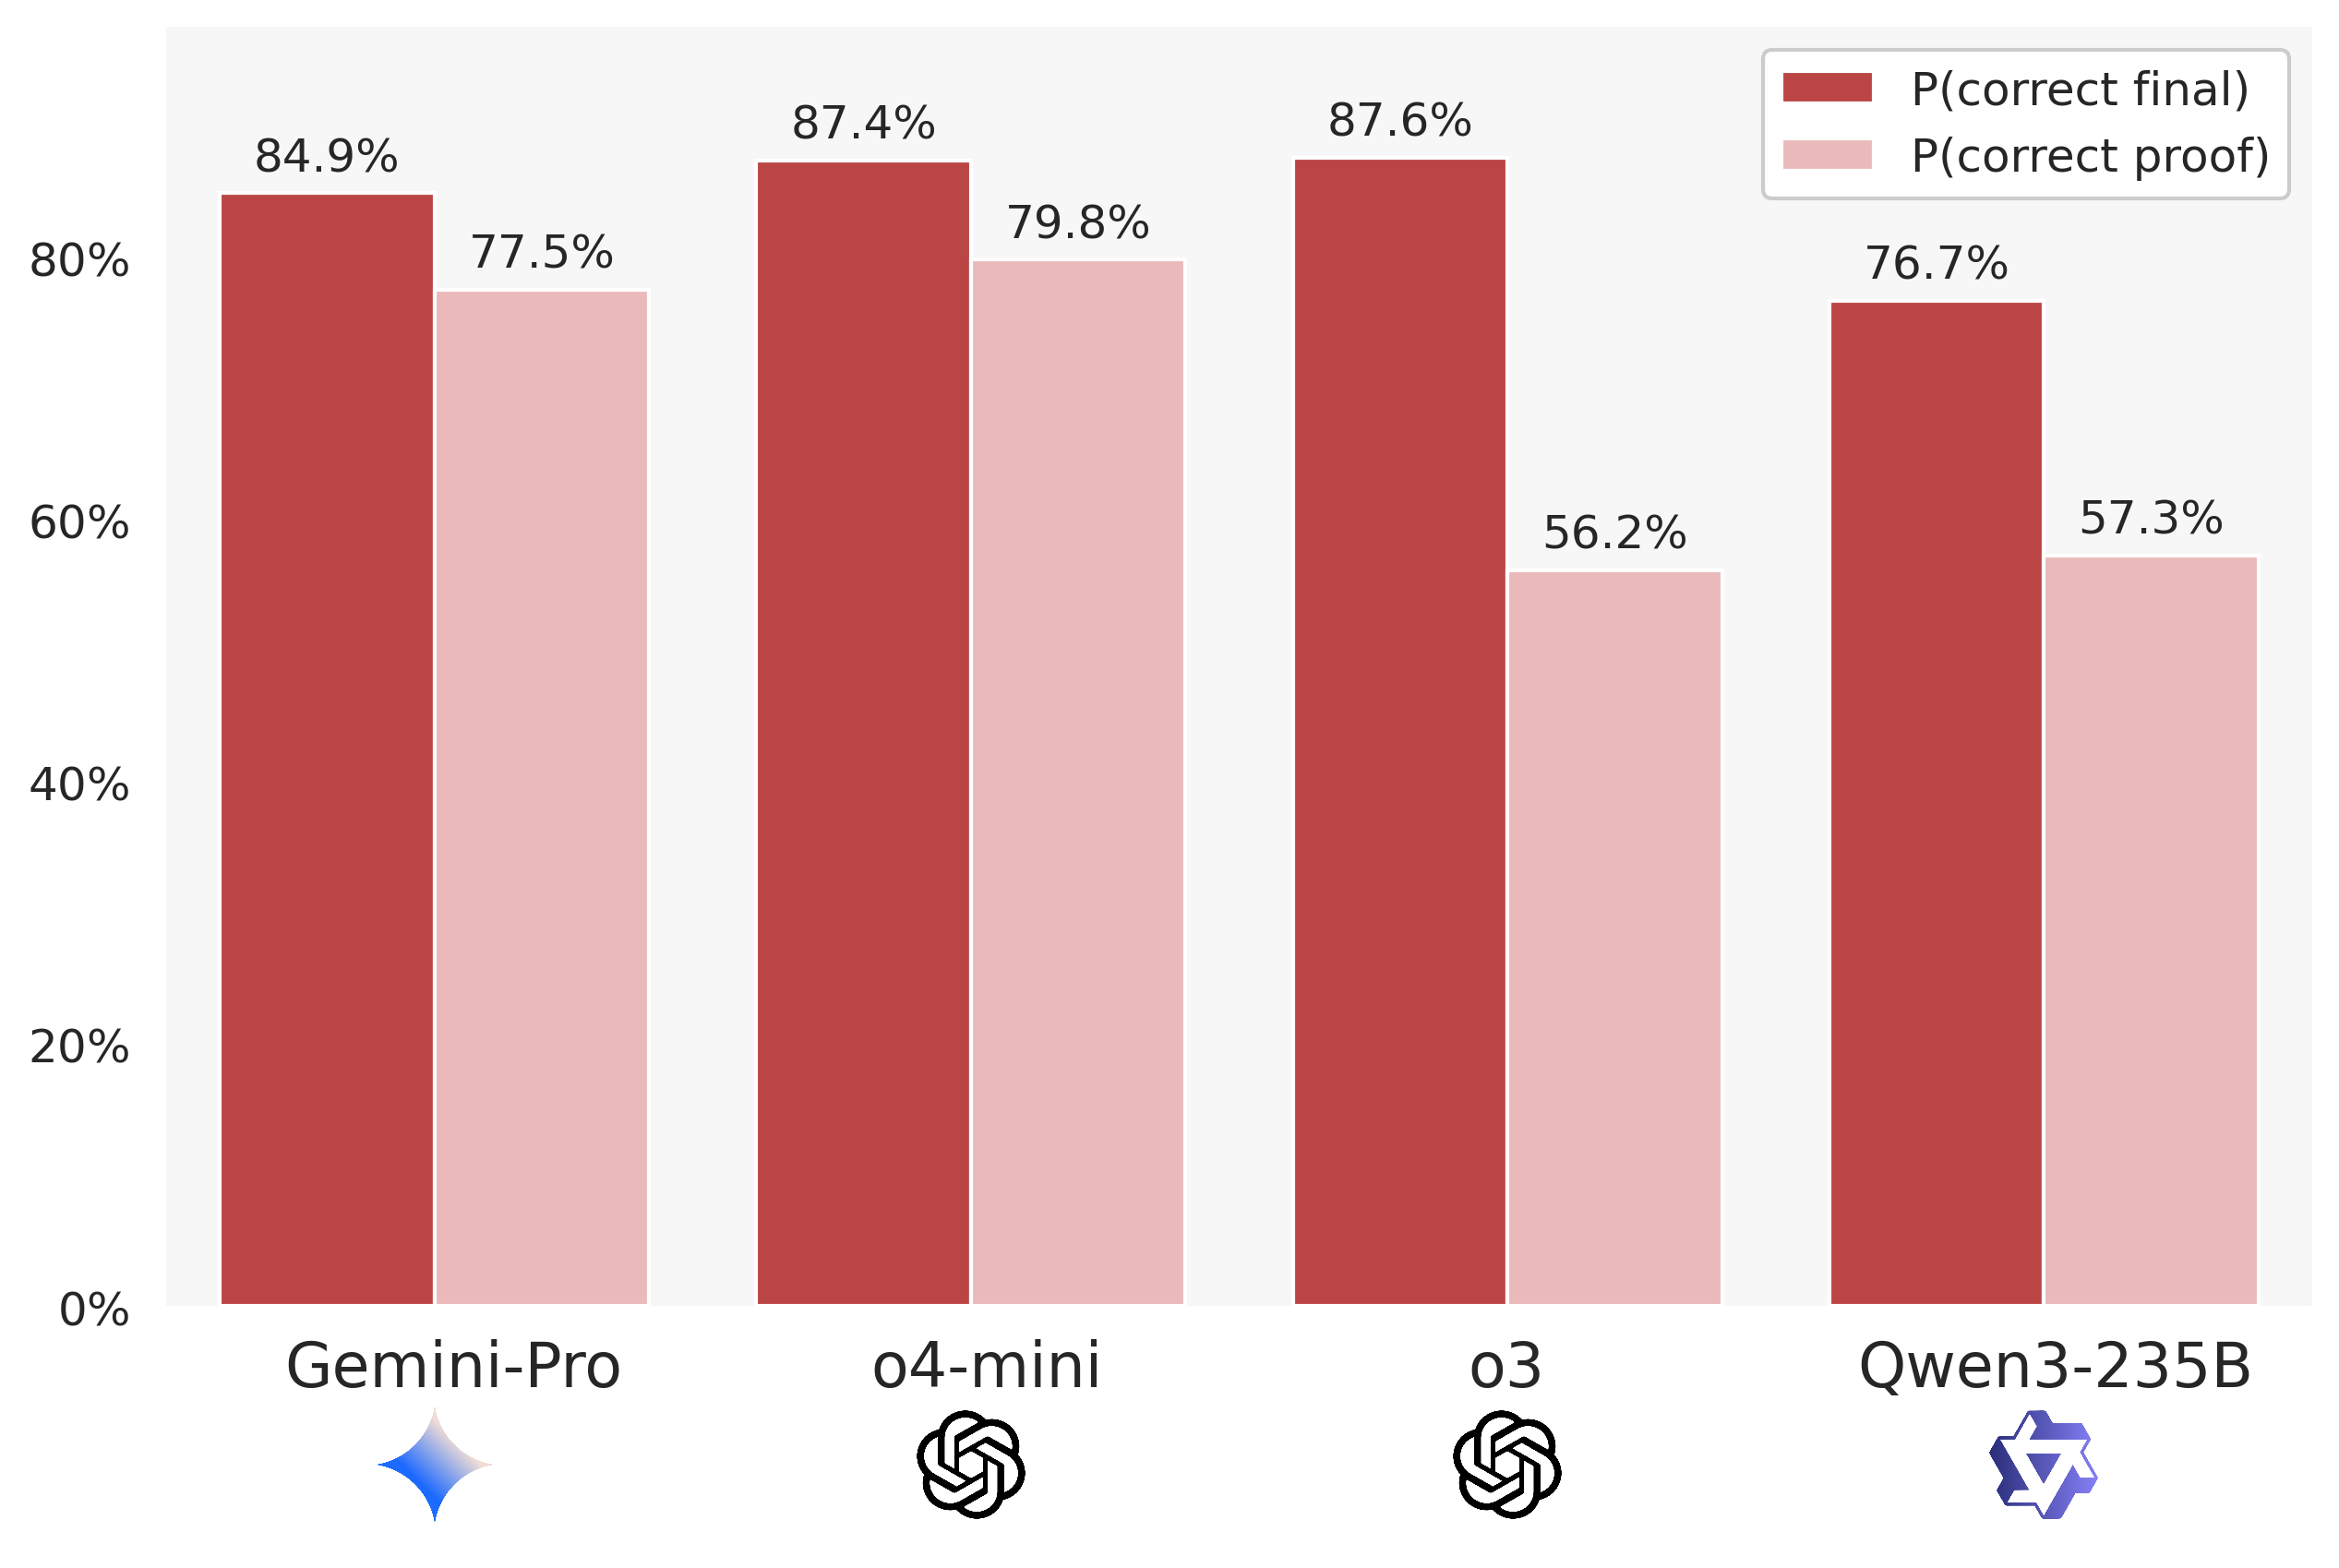

In [17]:
data_matharena = data[data["split"] == "matharena"]
problem_partitions = {
    model_id: np.mean(data_matharena[data_matharena["model_id"] == model_id]["mean_score"])
     for model_id in np.unique(data_matharena["model_id"])
}

model_scores = {
    "gemini/gemini-pro-2.5": [84.9 / 100, problem_partitions["gemini/gemini-pro-2.5"]],
    "openai/o4-mini--high": [87.4 / 100, problem_partitions["openai/o4-mini--high"]],
    "openai/o3": [87.6 / 100, problem_partitions["openai/o3"]],
    "qwen/qwen3_235b_a22b": [76.7 / 100, problem_partitions["qwen/qwen3_235b_a22b"]],
}
for model_id in model_scores:
    model_scores[model_id].append(model_scores[model_id][0] * model_scores[model_id][1])  # P(correct proof | correct final)
    model_scores[model_id] = [model_scores[model_id][0], model_scores[model_id][2]] 

plot(model_scores, ["P(correct final)", "P(correct proof)"], save_file="matharena.pdf", 
     label_size=12, shift_factor=0.035, colors=["#cf3131", "#f2b2b2"], add_values=True, values_label_size=12,)


/tmp/ipykernel_191429/1930485747.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] * len(ax.get_xticks()))


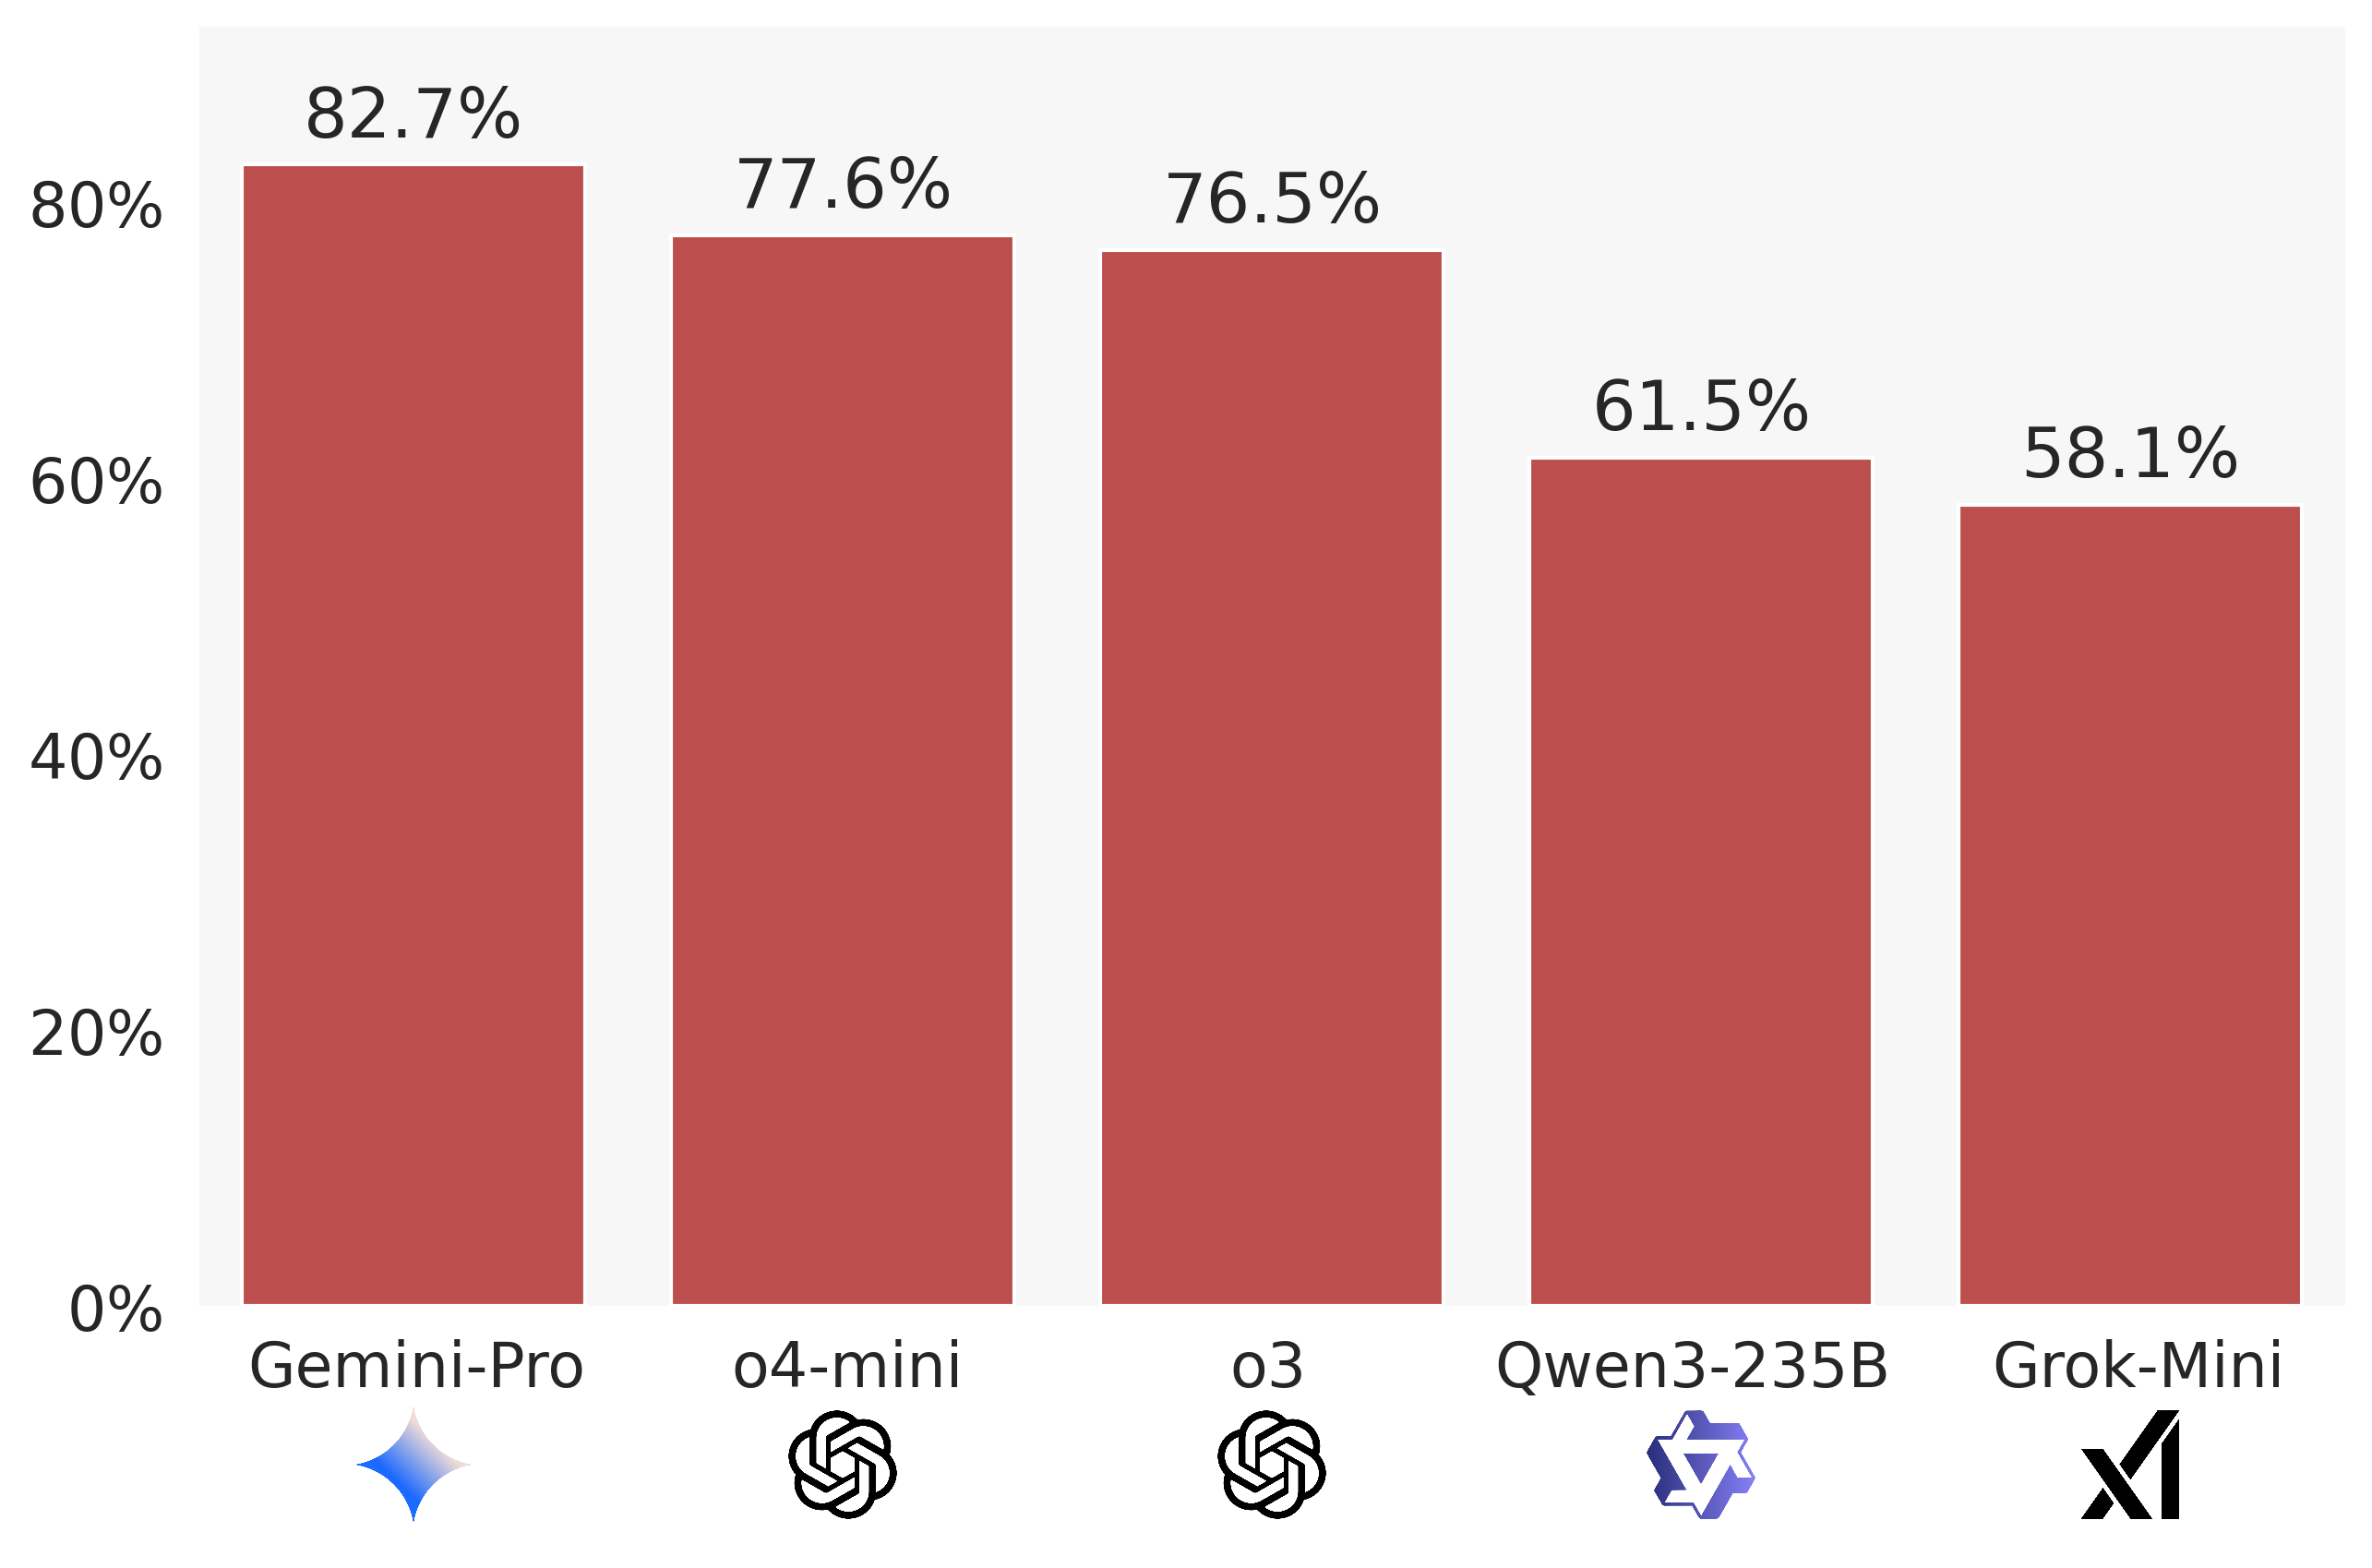

In [18]:
data_matharena = data[data["split"] == "putnambench"]
problem_partitions = {
    model_id: np.mean(data_matharena[data_matharena["model_id"] == model_id]["mean_score"])
     for model_id in np.unique(data_matharena["model_id"])
}
# sort by score
problem_partitions = {k: v for k, v in sorted(problem_partitions.items(), key=lambda item: item[1], reverse=True)}
plot(problem_partitions, ["Accuracy"], save_file="putnambench.pdf", 
     label_size=16, shift_factor=0.04, legend=False, add_values=True)


In [19]:
pass_at_n_df = (
    data.loc[data["split"] == "pass_at_n"]
        .groupby("problem_id")["mean_score"]
        .apply(np.array)          # or .agg(np.array)
)

In [20]:
from math import comb
import numpy as np

def pass_at_k(n, c, k):
    n = int(n)
    c = int(c)
    if c == 0:
        return 0.0
    if k > n:
        return c > 0
    if (n - c) < k:
        # Fewer wrong answers than draws ⇒ always hit a correct one.
        return 1.0
    return 1.0 - comb(n - c, k) / comb(n, k)

In [21]:
data_pass = pd.read_json("../data/pass_at_n.json")

In [22]:
from grading.utils import extract_solution
from grading.ranking.tournament import SwissTournament, BracketTournament
from grading.ranking.judgment import ModelAnswers, Judgments, Judgment
import os
from tqdm import tqdm
from loguru import logger

# remove the logger handlers
logger.remove()

os.environ["OPENAI_API_KEY"] = "sk-..."

def score_question(correctness, k, judge_type, judge_data, repetitions=1000):
    if judge_type == "random":
        return np.mean(correctness)
    scores = []
    for _ in range(repetitions):
        selected_indices = np.random.choice(len(correctness), k, replace=False)
        selected_indices = [int(i) for i in selected_indices]
        if not any(correctness[selected_indices]):
            scores.append(0.0)
        elif all(correctness[selected_indices]):
            scores.append(1.0)
        
        if judge_type == "discrete" or judge_type == "continuous":
            judge_data_selected = [judge_data[i] for i in selected_indices]
            extracted = [extract_solution(judge_data_selected[i][0]) for i in range(len(judge_data_selected))]
            if judge_type == "discrete":
                score_solutions = [0 if "incorrect" in extracted[i] else 1 for i in range(len(extracted))]
            else:
                score_solutions = [float(extracted[i]) for i in range(len(extracted))]
            
            # select the first solution with max score
            scores.append(correctness[selected_indices][np.argmax(score_solutions)])
        else:
            judge_data_here = []
            for judged_element in judge_data:
                if judged_element["first_answer_id"] in selected_indices and judged_element["second_answer_id"] in selected_indices:
                    first_id = selected_indices.index(judged_element["first_answer_id"])
                    second_id = selected_indices.index(judged_element["second_answer_id"])
                    judged_element_here = judged_element.copy()
                    judged_element_here["first_answer_id"] = first_id
                    judged_element_here["second_answer_id"] = second_id
                    judge_data_here.append(judged_element_here)
            model_answers = ModelAnswers(answers=selected_indices)
            judgments = Judgments(model_answers=model_answers, 
                                  judgments=[Judgment(**judged_element) for judged_element in judge_data_here])
            if judge_type == "ranking":
                tournament = SwissTournament(n_rounds=7, round_robin=True, n_answers=k, judgments=judgments, first_win_word="A", second_win_word="B",
                                            problem_statement="", judge_prompt="", model_config="../configs/models/openai/o4-mini--high.yaml")
            else:
                tournament = BracketTournament(max_losses=0, n_answers=k, judgments=judgments, first_win_word="A", second_win_word="B",
                                         problem_statement="", judge_prompt="", model_config="../configs/models/openai/o4-mini--high.yaml")
            tournament.run_tournament(output_folder=None)

            ranking = tournament.get_ranking()
            
            best_index = int(ranking.iloc[0]["answer"])

            scores.append(correctness[selected_indices][best_index])
    return np.mean(scores)

def score_questions(data, k, judge_type, repetitions=1000):
    scores = []
    for i, row in tqdm(data.iterrows()):
        correctness = np.array(row["correctness"])
        judge_data = row["judge_data"]
        if judge_type == "random":
            judge_data = judge_data["openai/o4-mini--high (Random Judge)"]
        elif judge_type == "discrete":
            judge_data = judge_data["openai/o4-mini--high (Discrete Judge)"]
        elif judge_type == "continuous":
            judge_data = judge_data["openai/o4-mini--high (Continuous Judge)"]
        else:
            judge_data = judge_data["openai/o4-mini--high (Ranking Judge)"]
        score = score_question(correctness, k, judge_type, judge_data, repetitions=repetitions)
        scores.append(score)
    return np.mean(scores)

In [23]:
# remove all problems with non-unique problem_id (only keep first occurrence)
data_pass = data_pass.drop_duplicates(subset=["problem_id"], keep="first")

In [24]:
pass_scores = [
    np.mean([pass_at_k(len(row["correctness"]), sum(row["correctness"]), k) 
    for i, row in data_pass.iterrows()]) for k in range(1, 9)
]

random_scores = [
    score_questions(data_pass, k, "random", repetitions=1000) for k in range(1, 9)
]
discrete_scores = [
    score_questions(data_pass, k, "discrete", repetitions=1000) for k in range(2, 9)
]
continuous_scores = [
    score_questions(data_pass, k, "continuous", repetitions=1000) for k in range(2, 9)
]
tournament_scores = [
    score_questions(data_pass, k, "ranking", repetitions=100) for k in range(2, 9)
]
bracket_scores = [
    score_questions(data_pass, k, "bracket", repetitions=100) for k in range(2, 9)
]

tournament_scores = [random_scores[0]] + tournament_scores
bracket_scores = [random_scores[0]] + bracket_scores
discrete_scores = [random_scores[0]] + discrete_scores
continuous_scores = [random_scores[0]] + continuous_scores

60it [00:00, 9327.58it/s]


60it [00:00, 8338.85it/s]
60it [00:00, 7265.38it/s]
60it [00:00, 8060.29it/s]
60it [00:00, 8636.47it/s]
60it [00:00, 4695.90it/s]
60it [00:00, 4513.08it/s]
60it [00:00, 4834.10it/s]
60it [00:03, 17.68it/s]
60it [00:04, 13.34it/s]
60it [00:04, 12.50it/s]
60it [00:05, 11.81it/s]
60it [00:05, 10.31it/s]
60it [00:07,  7.60it/s]
60it [00:08,  7.32it/s]
60it [00:03, 17.46it/s]
60it [00:04, 13.88it/s]
60it [00:04, 13.46it/s]
60it [00:04, 12.62it/s]
60it [00:04, 12.65it/s]
60it [00:04, 12.14it/s]
60it [00:05, 11.53it/s]
60it [01:14,  1.23s/it]
60it [01:18,  1.31s/it]
60it [01:29,  1.50s/it]
60it [01:39,  1.65s/it]
60it [01:36,  1.60s/it]
60it [01:44,  1.75s/it]
60it [01:48,  1.82s/it]
60it [01:07,  1.13s/it]
60it [01:03,  1.05s/it]
60it [01:31,  1.52s/it]
60it [01:29,  1.49s/it]
60it [01:26,  1.44s/it]
60it [01:22,  1.38s/it]
60it [01:20,  1.35s/it]


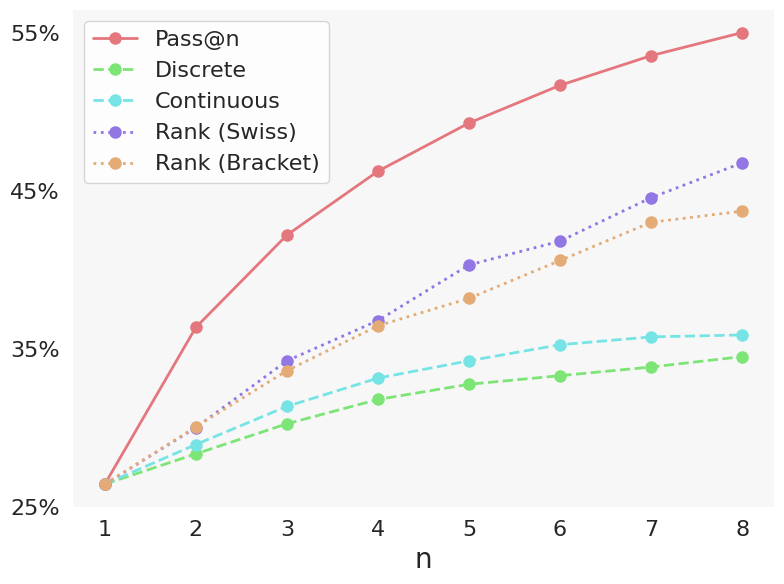

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
# colors = ['#000000',  # Black
#           '#1f77b4',  # Medium Blue
#           '#2ca02c',  # Green
#           '#d62728',  # Red
#           '#ff7f0e']  # Orange

colors = [
    "#e4767d",  # Pass@n
    "#7de476",  # Random Judge
    "#76e4e4",  # Discrete
    "#9276e4",  # Continuous
    "#e4ab76",  # Rank (Swiss)
]

ax.plot(range(1, 9), pass_scores, marker='o', linestyle='-', color=colors[0], linewidth=2, markersize=8, label='Pass@n')
# ax.plot(range(1, 9), random_scores, marker='o', linestyle='-', color="#7de476", linewidth=2, markersize=8, label='Random Judge')
ax.plot(range(1, 9), discrete_scores, marker='o', linestyle='--', color=colors[1], linewidth=2, markersize=8, label='Discrete')
ax.plot(range(1, 9), continuous_scores, marker='o', linestyle='--', color=colors[2], linewidth=2, markersize=8, label='Continuous')
ax.plot(range(1, 9), tournament_scores, marker='o', linestyle=':', color=colors[3], linewidth=2, markersize=8, label='Rank (Swiss)')
ax.plot(range(1, 9), bracket_scores, marker='o', linestyle=':', color=colors[4], linewidth=2, markersize=8, label='Rank (Bracket)')

ax.set_xticks(range(1, 9))
ax.set_xticklabels([f"{k}" for k in range(1, 9)])
# set ytick labels to percentages
ax.set_yticks([0.25, 0.35, 0.45, 0.55])
ax.set_yticklabels(['25%', '35%', '45%', '55%'])
ax.legend(fontsize=16, loc='upper left')
sns.despine(left=True, bottom=True)
ax.set_facecolor((0.97,0.97,0.97))
ax.set_xlabel('n', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()
fig.savefig("pass_at_n.pdf", bbox_inches='tight')

In [26]:
data_best_of_n = data[data["split"] == "best_of_n"]

data_best_of_n = data_best_of_n[data_best_of_n["model_id"].apply(lambda x: " BUG" not in x)]

correctness_per_problem_id = {}

for i, row in data_best_of_n.iterrows():
    problem_id = row["problem_id"]
    score = row["score"]
    if problem_id not in correctness_per_problem_id:
        correctness_per_problem_id[problem_id] = dict()
    correctness_per_problem_id[problem_id][row["model_id"]] = np.mean(score)

    for other_selector in row["other_selectors"]:
        correctness_per_problem_id[problem_id][other_selector] = np.mean(score)


problem_ids = list(correctness_per_problem_id.keys())
for problem_id in problem_ids:
    scores = correctness_per_problem_id[problem_id]
    if len(scores) < 4 or any("V1" in model_id or "BUG" in model_id for model_id in scores.keys()):
        del correctness_per_problem_id[problem_id]

In [27]:
n_problems_here = len(correctness_per_problem_id)

scores_per_judge = {
    judge_id: np.mean([correctness_per_problem_id[problem_id][judge_id] for problem_id in correctness_per_problem_id.keys()])
    for judge_id in correctness_per_problem_id[list(correctness_per_problem_id.keys())[0]].keys()
}


tournament_score = len(data_pass) * tournament_scores[-1] + n_problems_here * scores_per_judge["openai/o4-mini--high (Ranking Judge)"]
random_score = len(data_pass) * random_scores[-1] + n_problems_here * scores_per_judge["openai/o4-mini--high (Random Judge)"]
discrete_score = len(data_pass) * discrete_scores[-1] + n_problems_here * scores_per_judge["openai/o4-mini--high (Discrete Judge)"]
continuous_score = len(data_pass) * continuous_scores[-1] + n_problems_here * scores_per_judge["openai/o4-mini--high (Continuous Judge)"]

tournament_score = tournament_score / (len(data_pass) + n_problems_here)
random_score = random_score / (len(data_pass) + n_problems_here)
discrete_score = discrete_score / (len(data_pass) + n_problems_here)
continuous_score = continuous_score / (len(data_pass) + n_problems_here)

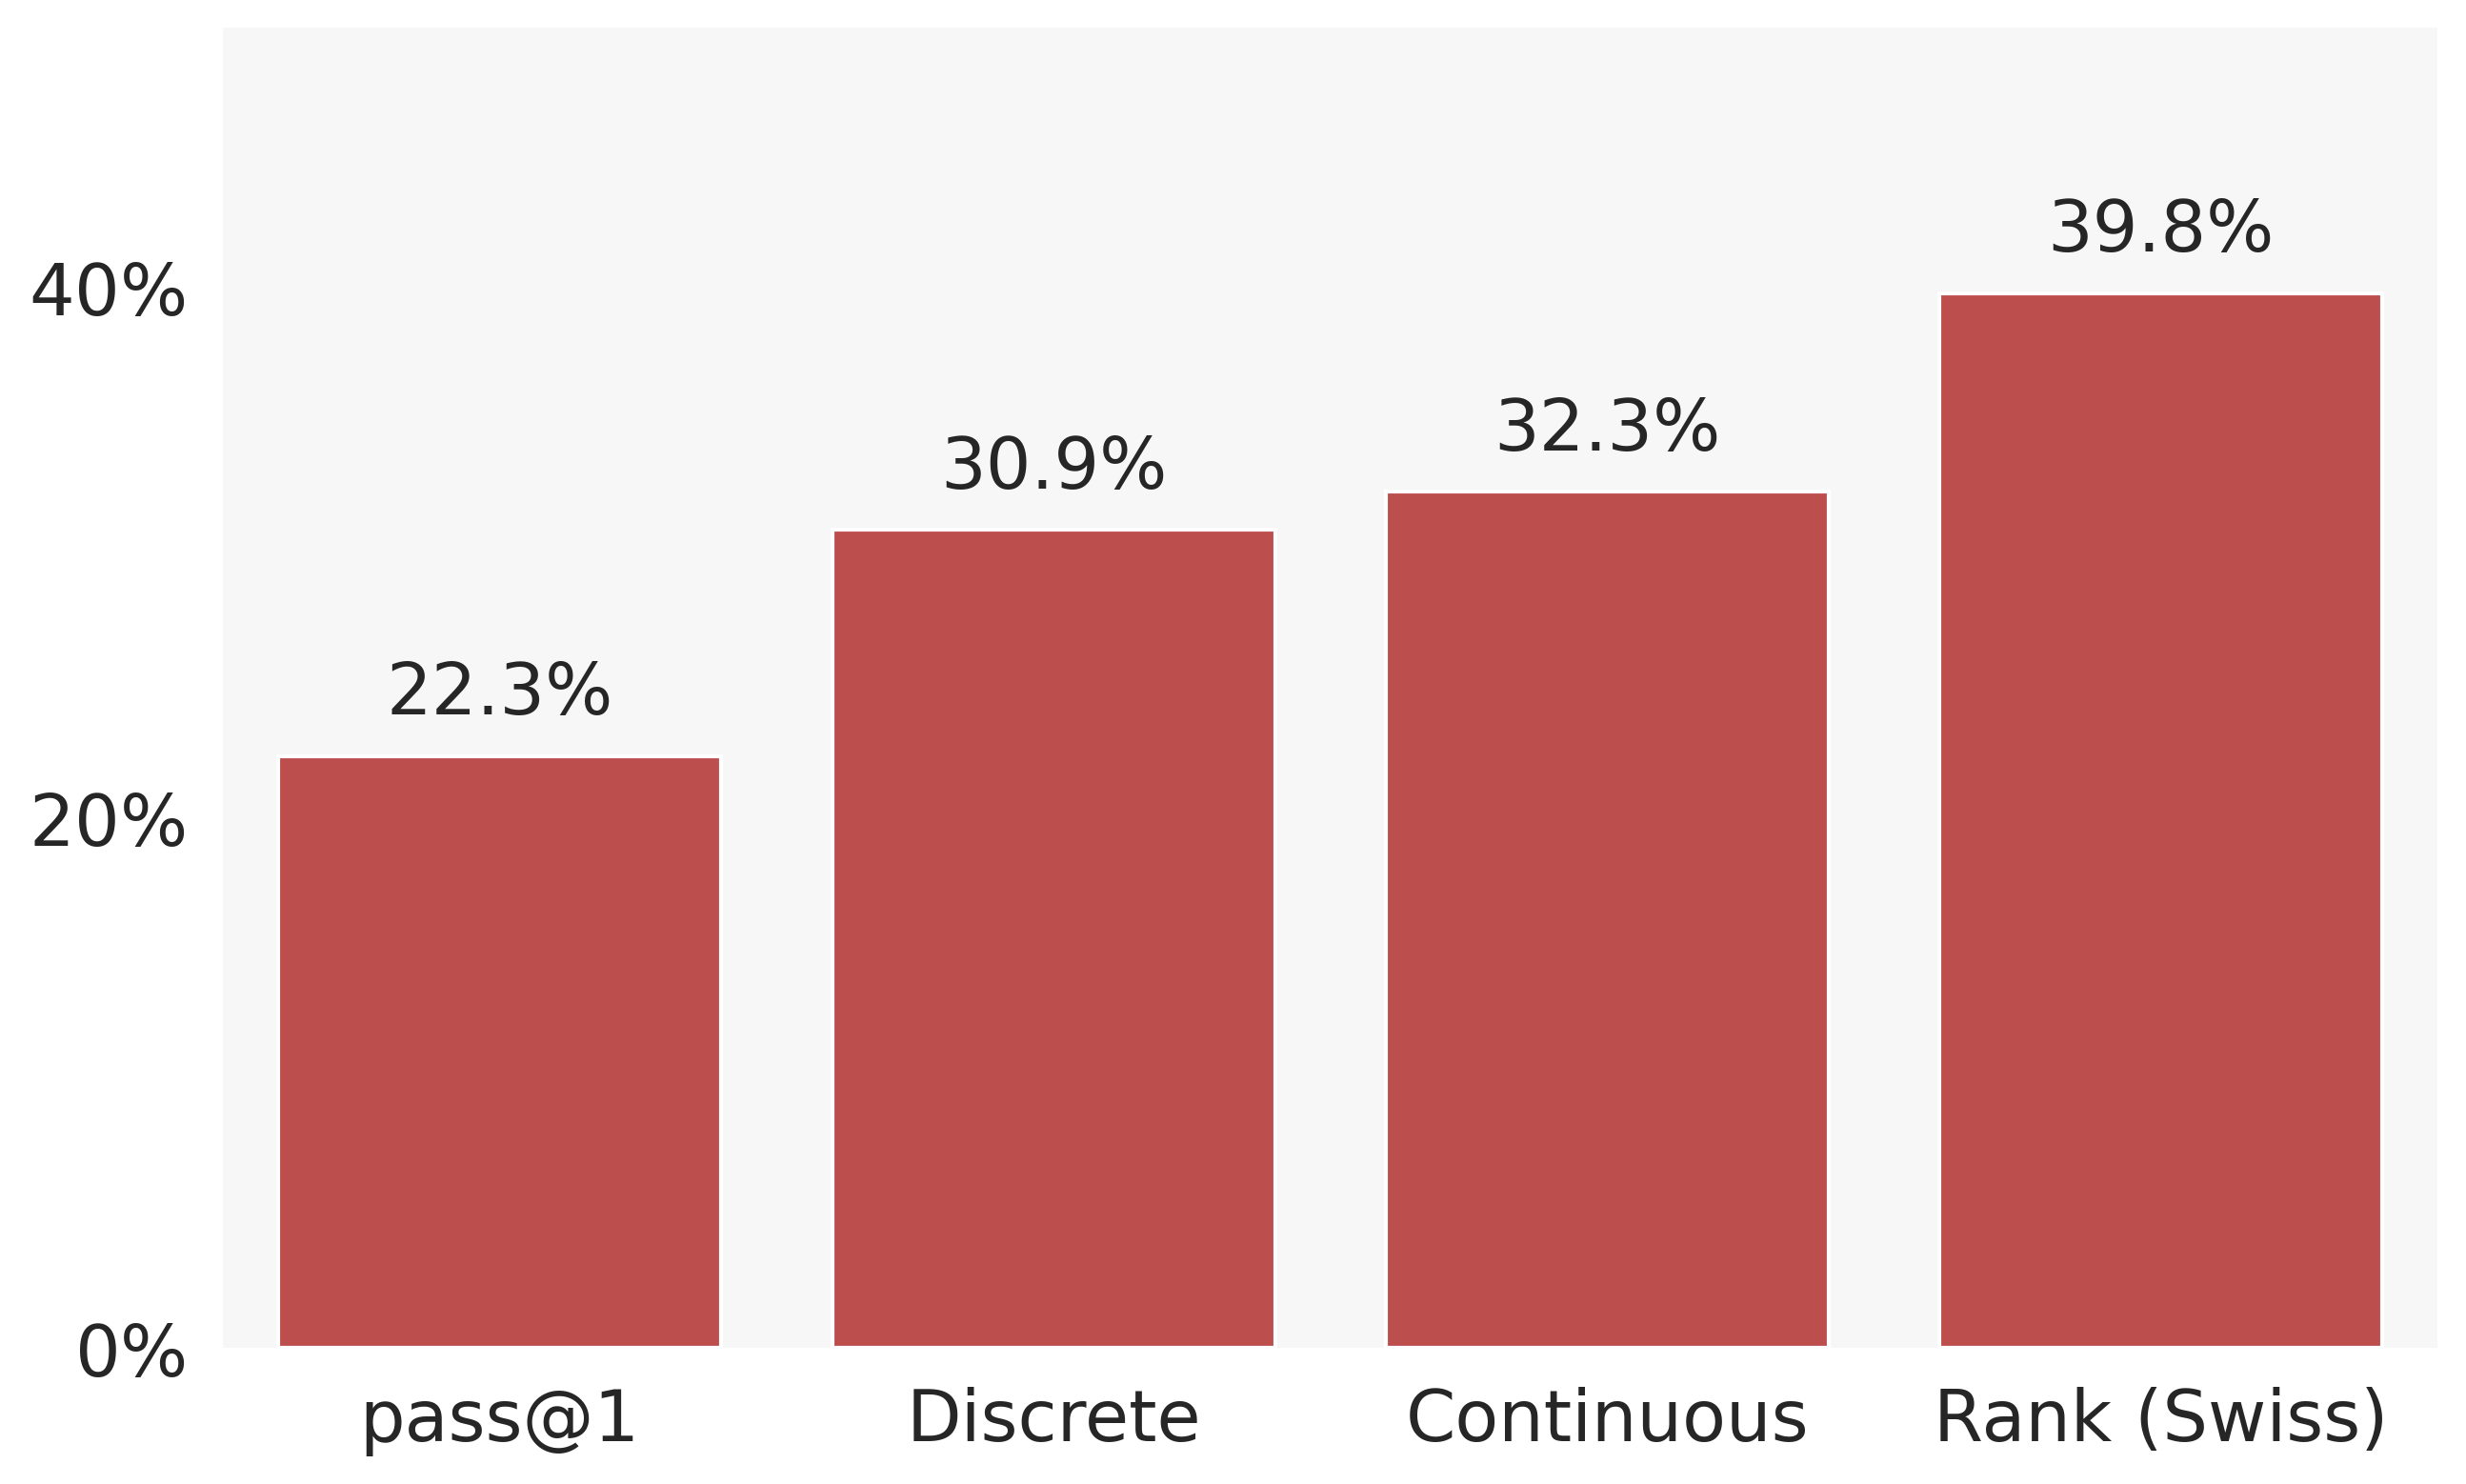

In [28]:
plot(
        {       
                "pass@1": [random_score],
                "Discrete": [discrete_score],
                "Continuous": [continuous_score],
                "Rank (Swiss)": [tournament_score],
                
        },
        ["Score"],
        save_file="best_of_n.pdf",
        legend=False, 
        logos=False,
        add_values=True,
)


/tmp/ipykernel_191429/1522956953.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][1].set_xticklabels(["Formal", "Informal"], fontsize=16)
/tmp/ipykernel_191429/1522956953.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1][0].set_xticklabels(["o3", "Gemini-Pro"], fontsize=16)
/tmp/ipykernel_191429/1522956953.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(["Human", "Best Model"], fontsize=16)


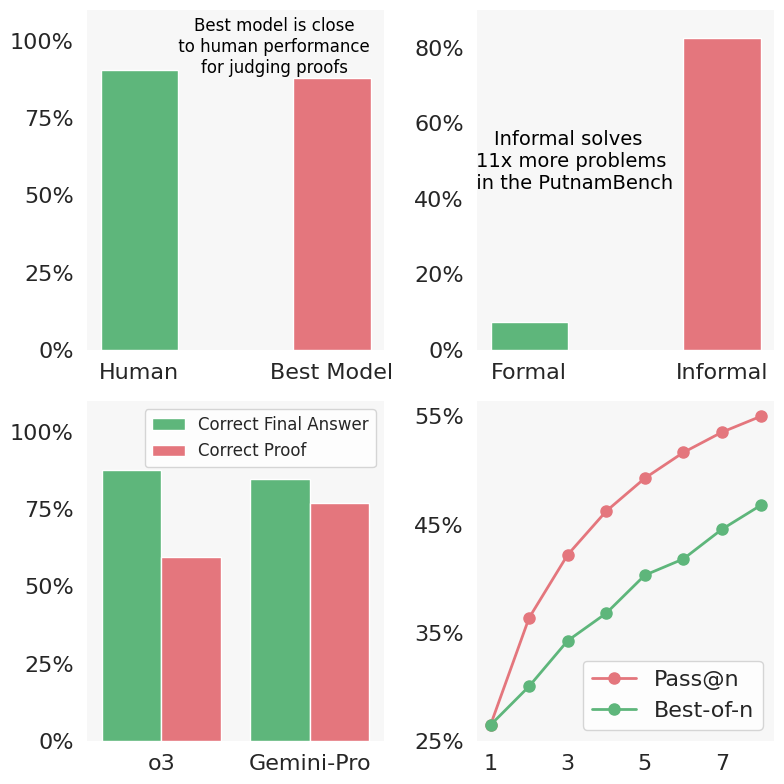

In [29]:
fig, ax = plt.subplots(figsize=(8, 8), nrows=2, ncols=2)

# on ax[1][1] we put the best@n plot with just pass@n and tournament_scores
ax[1][1].plot(range(1, 9), pass_scores, marker='o', linestyle='-', color='#e4767d', linewidth=2, markersize=8, label='Pass@n')
ax[1][1].plot(range(1, 9), tournament_scores, marker='o', linestyle='-', color="#5eb67b", linewidth=2, markersize=8, label='Best-of-n')
ax[1][1].set_xticks([1,3,5,7])
# set xticlabels font size
ax[1][1].set_xticklabels([1,3,5,7], fontsize=16)
ax[1][1].legend(fontsize=16, loc='lower right')
ax[1][1].set_yticks([0.25, 0.35, 0.45, 0.55])
ax[1][1].set_yticklabels([f'{int(i * 100)}%' for i in [0.25, 0.35, 0.45, 0.55]], fontsize=16)
sns.despine(left=True, bottom=True)
ax[1][1].set_facecolor((0.97,0.97,0.97))


# on ax[1][0] we put two bars, one for formal models at 10% and one for informal models at 80%
ax[0][1].bar(["Formal Models", "Informal Models"], [49 / 658, 0.827], color=["#5eb67b", "#e4767d"], width=0.4)
ax[0][1].set_ylim(0, 0.9)
ax[0][1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax[0][1].set_yticklabels([f'{int(i * 100)}%' for i in [0, 0.2, 0.4, 0.6, 0.8]], fontsize=16)
ax[0][1].set_xticklabels(["Formal", "Informal"], fontsize=16)
ax[0][1].set_facecolor((0.97,0.97,0.97))

# draw an arrow from the top of the formal bar to the top of the informal bar
# ax[1][0].annotate('', xy=(0.75, 0.75), xytext=(0, 0.1),
#             arrowprops=dict(arrowstyle='->', lw=2, color='grey'),
#             fontsize=16, ha='center', va='center')
# add text saying "Informal models are 8.55x better than formal models"
ax[0][1].text(0.22, 0.5, "Informal solves \n11x more problems\n in the PutnamBench", 
            fontsize=14, ha='center', va='center', color='black')


# ax[0][1] contains two models with correct final answer and correct proof bars for each model, use seaborn

model_scores = {
    "o3": [0.876, 0.595],
    "gemini-pro-2.5": [0.849, 0.77],
}

melted_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=["Correct Final Answer", "Correct Proof"]).reset_index()
melted_df.rename(columns={'index': 'Model'}, inplace=True)
sns.barplot(data=melted_df.melt(id_vars='Model', var_name='Accuracy Type', value_name='Accuracy Value'),
            x='Model', y='Accuracy Value', hue='Accuracy Type',
            palette=["#5eb67b", "#e4767d"], ax=ax[1][0], saturation=1)

ax[1][0].set_xticklabels(["o3", "Gemini-Pro"], fontsize=16)
ax[1][0].set_ylim(0, 1.1)
# make legend without title
leg = ax[1][0].legend(title=None, fontsize=12, loc='upper right')


ax[1][0].set_xlabel('')
ax[1][0].set_ylabel('')
ax[1][0].set_yticks([0, 0.25, 0.5, 0.75, 1])
ax[1][0].set_yticklabels([f'{int(i * 100)}%' for i in [0, 0.25, 0.5, 0.75, 1]], fontsize=16)
ax[1][0].set_facecolor((0.97,0.97,0.97))

# on [0][0] we put two bars, one human at 94.2% and one AI at 83.6%
ax[0][0].bar(["Human", "Best Model"], [0.906, 0.881], color=["#5eb67b", "#e4767d"], width=0.4)
ax[0][0].set_ylim(0, 1.1)
ax[0][0].set_yticks([0, 0.25, 0.5, 0.75, 1])
ax[0][0].set_yticklabels([f'{int(i * 100)}%' for i in [0, 0.25, 0.5, 0.75, 1]], fontsize=16)
ax[0][0].set_xticklabels(["Human", "Best Model"], fontsize=16)
ax[0][0].set_facecolor((0.97,0.97,0.97))

ax[0][0].text(0.7, 0.98, "Best model is close\n to human performance \nfor judging proofs", 
            fontsize=12, ha='center', va='center', color='black')

fig.tight_layout()
plt.show()
fig.savefig("summary.pdf", bbox_inches='tight')